In [1]:
import os
import re
import json
import ast

from pathlib import Path
from copy import deepcopy
from datetime import date, datetime, timedelta


import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer


import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from pandarallel import pandarallel

import dgl
import torch

from transformers import AutoTokenizer, AutoModel

In [2]:
%matplotlib inline
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
df_book = pd.read_csv('datasets/kaggle_books.csv', sep=";", error_bad_lines=False, encoding="latin-1")
df_ratings = pd.read_csv('datasets/kaggle_ratings.csv', sep=";", error_bad_lines=False, encoding="latin-1")
df_user = pd.read_csv('datasets/kaggle_users.csv', sep=";", error_bad_lines=False, encoding="latin-1")

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/home/chinu/.conda/envs/mlenv/lib/python3.9/site-packages/IPython/core/int

In [5]:
print("Shape of the Book DF is : ", df_book.shape)
df_book.head()

Shape of the Book DF is :  (271360, 8)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
print("Shape of the Ratings DF is : ", df_ratings.shape)
df_ratings.head()

Shape of the Ratings DF is :  (1149780, 3)


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [7]:
print("Shape of the User DF is : ", df_user.shape)
df_user.head()

Shape of the User DF is :  (278858, 3)


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [8]:
df_user.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [9]:
df_ratings.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [9]:
df_ratings = df_ratings.astype({'User-ID': 'category', 'ISBN': 'category'})
df_book['ISBN'] = df_book['ISBN'].astype('category')
df_user['User-ID'] = df_user['User-ID'].astype('category')

In [10]:
# df_book.columns
df_book.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L',], inplace=True)
df_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


In [11]:
df_rating_bookid = df_ratings[df_ratings['ISBN'].isin(df_book['ISBN'].unique())]
df_rating_bookid.shape

(1031136, 3)

In [12]:
df_rating_avail = df_rating_bookid[df_rating_bookid['User-ID'].isin(df_user['User-ID'].unique())]
df_rating_avail.shape

(1031136, 3)

In [13]:
df_book = df_book[df_book['ISBN'].isin(df_rating_avail['ISBN'])]
df_book.shape

(270151, 5)

In [14]:
df_user = df_user[df_user['User-ID'].isin(df_rating_avail['User-ID'])]
df_user.shape

(92106, 3)

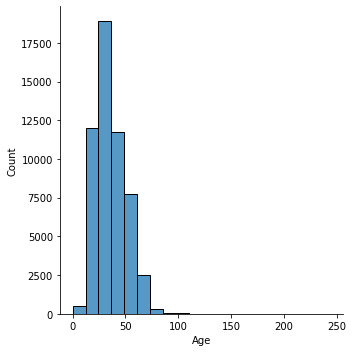

In [15]:
sns.displot(df_user['Age'], bins=20)

<AxesSubplot:xlabel='Age'>

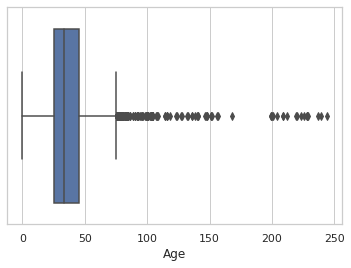

In [16]:
sns.set_theme(style="whitegrid")
sns.boxplot(x=df_user["Age"])

In [17]:
df_user.isnull().sum()

User-ID         0
Location        0
Age         38219
dtype: int64

In [18]:
for index, row in df_user[df_user['Age'] > 119].iterrows():
    df_user['Age'][df_user.index == index] = row['Age'] * 0.1


# df_user['Age'].mode()
df_user['Age'].fillna(df_user['Age'].mode()[0], inplace=True)

df_user.isnull().sum()

<ipython-input-18-16ac22d43409>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['Age'][df_user.index == index] = row['Age'] * 0.1
<ipython-input-18-16ac22d43409>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['Age'][df_user.index == index] = row['Age'] * 0.1
<ipython-input-18-16ac22d43409>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['Age'][df_user.index == index] = row['Age'] * 0.1
<ipython-input-18-16ac

User-ID     0
Location    0
Age         0
dtype: int64

In [19]:
df_book.reset_index(drop=True, inplace=True)
df_user.reset_index(drop=True, inplace=True)
df_rating_avail.reset_index(drop=True, inplace=True)

In [20]:
df_book.rename(columns={"Year-Of-Publication": "publication_year"}, inplace=True)
df_book.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'publication_year', 'Publisher'], dtype='object')

In [31]:
pd.to_numeric(df_book['publication_year'])

ValueError: Unable to parse string "DK Publishing Inc" at position 221447

In [33]:
df_book.iloc[221447]#['Book-Title']
# df_book.info()

'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\\";James Buckley"'

In [23]:
df_book.at[209398, 'Publisher'] = 'DK Publishing Inc'
df_book.at[209398, 'Book-Author'] = 'Michael Teitelbaum'
df_book.at[209398, 'publication_year'] = '2000'
df_book.at[209398, 'Book-Title'] = 'Creating the X-Men, How It All Began (Level 4: Proficient Readers)'

In [29]:
df_book.at[220500, 'Publisher'] = 'Gallimard'
df_book.at[220500, 'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'
df_book.at[220500, 'publication_year'] = '2003'
df_book.at[220500, 'Book-Title'] = 'Peuple du ciel, suivi de \'Les Bergers'

In [34]:
df_book.at[221447, 'Publisher'] = 'DK Publishing Inc'
df_book.at[221447, 'Book-Author'] = 'James Buckley'
df_book.at[221447, 'publication_year'] = '2000'
df_book.at[221447, 'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'

In [36]:
df_book['publication_year'] = pd.to_numeric(df_book['publication_year'])

In [37]:
df_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270151 entries, 0 to 270150
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   ISBN              270151 non-null  object
 1   Book-Title        270151 non-null  object
 2   Book-Author       270150 non-null  object
 3   publication_year  270151 non-null  int64 
 4   Publisher         270149 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.3+ MB


In [38]:
df_rating_avail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031136 entries, 0 to 1031135
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1031136 non-null  int64 
 1   ISBN         1031136 non-null  object
 2   Book-Rating  1031136 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 23.6+ MB


In [39]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92106 entries, 0 to 92105
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User-ID   92106 non-null  int64  
 1   Location  92106 non-null  object 
 2   Age       92106 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.1+ MB


In [40]:
df_rating_avail.reset_index(drop=True, inplace=True)
df_rat_rand = df_rating_avail.sample(frac=1, random_state=7)
training_test_index = round(len(df_rat_rand) * 0.7)
training_test_index

721795

In [41]:
training_set = df_rat_rand[:training_test_index].reset_index(drop=True)
testing_set = df_rat_rand[training_test_index:].reset_index(drop=True)

In [43]:
#Removed enties of non existing user id and isbn from test not available in train

test_set = testing_set[testing_set['User-ID'].isin(training_set['User-ID']) &
                      testing_set['ISBN'].isin(training_set['ISBN'])]

df_user = df_user[df_user['User-ID'].isin(training_set['User-ID'])]
df_book = df_book[df_book['ISBN'].isin(training_set['ISBN'])]

In [44]:
print("Shape of the test_set array = ", test_set.shape)
print("Shape of the df_user array = ", df_user.shape)
print("Shape of the training_set array = ", training_set.shape)
print("Shape of the df_book array = ", df_book.shape)

Shape of the test_set array =  (239130, 3)
Shape of the df_user array =  (75627, 3)
Shape of the training_set array =  (721795, 3)
Shape of the df_book array =  (221332, 5)


In [45]:
df_book.reset_index(drop=True, inplace=True)
df_user.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)
training_set.reset_index(drop=True, inplace=True)

In [46]:
train_data = training_set.astype({'User-ID': 'category', 'ISBN': 'category'})
test_data = test_set.astype({'User-ID': 'category', 'ISBN': 'category'})
df_user = df_user.astype({'User-ID': 'category'})
df_book = df_book.astype({'ISBN': 'category'})

In [47]:
print("DF book", df_book.info())
print("DF User", df_user.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221332 entries, 0 to 221331
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   ISBN              221332 non-null  category
 1   Book-Title        221332 non-null  object  
 2   Book-Author       221331 non-null  object  
 3   publication_year  221332 non-null  int64   
 4   Publisher         221331 non-null  object  
dtypes: category(1), int64(1), object(3)
memory usage: 17.4+ MB
DF book None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75627 entries, 0 to 75626
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   User-ID   75627 non-null  category
 1   Location  75627 non-null  object  
 2   Age       75627 non-null  float64 
dtypes: category(1), float64(1), object(1)
memory usage: 4.0+ MB
DF User None


In [48]:
train_user_ids = torch.LongTensor(train_data['User-ID'].cat.codes.values)
train_item_ids = torch.LongTensor(train_data['ISBN'].cat.codes.values)
train_ratings = torch.LongTensor(train_data['Book-Rating'].values)
test_user_ids = torch.LongTensor(test_data['User-ID'].cat.codes.values)
test_item_ids = torch.LongTensor(test_data['ISBN'].cat.codes.values)
test_ratings = torch.LongTensor(test_data['Book-Rating'].values)

<ipython-input-48-d3058a5be1c0>:1: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755883846/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  train_user_ids = torch.LongTensor(train_data['User-ID'].cat.codes.values)


In [49]:
train_ratings

tensor([7, 0, 7,  ..., 8, 0, 0])

In [50]:
graph = dgl.heterograph({
    # Heterogeneous graphs are organized as a dictionary of edges connecting two types of nodes.
    # We specify the edges of a type simply with a pair of user ID array and item ID array.
    ('user', 'read', 'item'): (train_user_ids, train_item_ids),
    # Since DGL graphs are directional, we need an inverse relation from items to users as well.
    ('item', 'read-by', 'user'): (train_item_ids, train_user_ids)
})
graph

Graph(num_nodes={'item': 221332, 'user': 75627},
      num_edges={('item', 'read-by', 'user'): 721795, ('user', 'read', 'item'): 721795},
      metagraph=[('item', 'user', 'read-by'), ('user', 'item', 'read')])

DGLError: Invalid key "0". Must be one of the edge types.

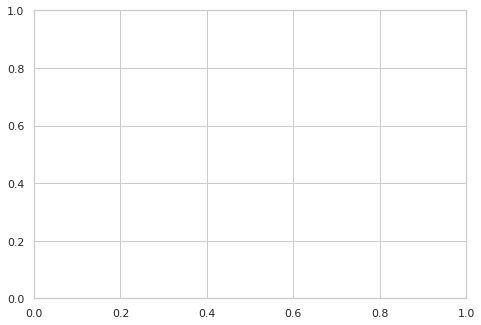

In [51]:
import networkx as nx

# The metagraph is shown in the figure below.  Note the bidirectional arrows.
# nx.draw_networkx_edges(graph.metagraph, )
nx.draw(graph)

In [53]:
df_user['User-ID'] = df_user['User-ID'].astype('category')
df_user['User-ID'] = df_user['User-ID'].cat.set_categories(train_data['User-ID'].cat.categories)

df_user = df_user.dropna(subset=['User-ID'])
df_user['User-ID'] = df_user['User-ID'].cat.codes
df_user = df_user.sort_values('User-ID')

df_book['ISBN'] = df_book['ISBN'].astype('category')
df_book['ISBN'] = df_book['ISBN'].cat.set_categories(train_data['ISBN'].cat.categories)

df_book = df_book.dropna(subset=['ISBN'])
df_book['ISBN'] = df_book['ISBN'].cat.codes
df_book = df_book.sort_values('ISBN')


In [54]:
user_age = df_user['Age'].values // 10
num_user_age_bins = user_age.max() + 1 

In [73]:
len(np.unique(user_age)) == num_user_age_bins

True

In [55]:
user_age.shape

(75627,)

In [ ]:
def pre_process(string_value):
    sentence = str(string_value)
    cleantext = re.sub(r"[^a-zA-Z0-9]+", ' ', sentence.lower().strip())
    rem_url=re.sub(r'http\S+', '',cleantext)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_url)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    return " ".join(filtered_words)

df_book["authors"] = df_book['Book-Author'].parallel_apply(pre_process)
df_book["title"] = df_book['Book-Title'].parallel_apply(pre_process)
df_book["publishers"] = df_book['Publisher'].parallel_apply(pre_process)
df_user['location'] = df_user['Location'].parallel_apply(pre_process)

In [ ]:
tf = TfidfVectorizer(ngram_range=(1,6), min_df = 0, stop_words = 'english', sublinear_tf=True)
tfidf_matrix_user_loc = tf.fit_transform(df_user['location'])

tfidf_matrix_user_loc

In [ ]:
loc_user = np.hstack(tfidf_matrix_user_loc)
loc_user.shape


In [ ]:
cols = ['authors', 'publishers']
df_book['meta_info'] = df_book[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [ ]:
tf_book = TfidfVectorizer(ngram_range=(1,6), min_df = 0, stop_words = 'english', sublinear_tf=True)
tfidf_matrix_book_meta = tf_book.fit_transform(df_book['meta_info'])

tfidf_matrix_book_meta.shape

In [ ]:
meta_book = np.hstack(tfidf_matrix_book_meta)
meta_book.shape

In [56]:
graph.nodes['user'].data['age'] = torch.LongTensor(user_age)

In [61]:
pub_year = df_book['publication_year'].values
pub_year.dtype

dtype('int64')

In [63]:
graph.nodes['item'].data['year'] = torch.LongTensor(pub_year)

In [77]:
num_pub_years = len(np.unique(pub_year))

In [65]:
# Assign ratings
graph.edges['read'].data['rating'] = torch.LongTensor(train_ratings)
graph.edges['read-by'].data['rating'] = torch.LongTensor(train_ratings)

In [66]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_user_ids, train_item_ids, train_ratings)
test_dataset = TensorDataset(test_user_ids, test_item_ids, test_ratings)

In [67]:
class MinibatchSampler(object):
    def __init__(self, graph, num_layers):
        self.graph = graph
        self.num_layers = num_layers
        
    def sample(self, batch):
        # Convert the list of user-item-rating triplets into a triplet of users, items, and ratings
        users, items, ratings = zip(*batch)
        users = torch.stack(users)
        items = torch.stack(items)
        ratings = torch.stack(ratings)
        
        # Create a pair graph (Step 1)
        pair_graph = dgl.heterograph(
            {('user', 'read', 'item'): (users, items)},
            num_nodes_dict={'user': self.graph.number_of_nodes('user'), 'item': self.graph.number_of_nodes('item')})
        
        # Compact the graph (Step 2)
        pair_graph = dgl.compact_graphs(pair_graph)
        # Assign ratings to the graph
        pair_graph.edata['rating'] = ratings
        
        # Construct blocks (Step 3)
        seeds = {'user': pair_graph.nodes['user'].data[dgl.NID],
                 'item': pair_graph.nodes['item'].data[dgl.NID]}
        blocks = self.construct_blocks(seeds, (users, items))
        
        # Copy node features from original graph to the sampled block.
        # Note that for our model we only need to copy the features to the source side of the first block.
        # The node features of other blocks would be computed by our model.
        for feature_name in self.graph.nodes['user'].data.keys():
            blocks[0].srcnodes['user'].data[feature_name] = \
                self.graph.nodes['user'].data[feature_name][blocks[0].srcnodes['user'].data[dgl.NID]]
        for feature_name in self.graph.nodes['item'].data.keys():
            blocks[0].srcnodes['item'].data[feature_name] = \
                self.graph.nodes['item'].data[feature_name][blocks[0].srcnodes['item'].data[dgl.NID]]

        return pair_graph, blocks
        
    def construct_blocks(self, seeds, user_item_pairs_to_remove):
        blocks = []
        users, items = user_item_pairs_to_remove
        for i in range(self.num_layers):
            # We take all neighbors to form the sampled graph for computing the node representations on the
            # current layer.
            sampled_graph = dgl.in_subgraph(self.graph, seeds)
            # Find the sampled edge IDs for both directions
            sampled_eids = sampled_graph.edges['read'].data[dgl.EID]
            sampled_eids_rev = sampled_graph.edges['read-by'].data[dgl.EID]
            
            # A subtlety of rating prediction and link prediction is that, when we train on the pair of user A
            # and item 1, we don't want to actually tell the GNN that "user A has a connection to item 1".  So
            # we should remove all edges connecting the training pairs from the sampled graph.
            _, _, edges_to_remove = sampled_graph.edge_ids(users, items, etype='read', return_uv=True)
            _, _, edges_to_remove_rev = sampled_graph.edge_ids(items, users, etype='read-by', return_uv=True)
            sampled_with_edges_removed = dgl.remove_edges(
                sampled_graph, {'read': edges_to_remove, 'read-by': edges_to_remove_rev})
            sampled_eids = sampled_eids[sampled_with_edges_removed.edges['read'].data[dgl.EID]]
            sampled_eids_rev = sampled_eids_rev[sampled_with_edges_removed.edges['read-by'].data[dgl.EID]]
            
            # Create a block from the sampled graph.
            block = dgl.to_block(sampled_with_edges_removed, seeds)
            blocks.insert(0, block)
            seeds = {'user': block.srcnodes['user'].data[dgl.NID],
                     'item': block.srcnodes['item'].data[dgl.NID]}
            
            # Copy the ratings to the edges of the sampled block
            block.edges['read'].data['rating'] = \
                self.graph.edges['read'].data['rating'][sampled_eids]
            block.edges['read-by'].data['rating'] = \
                self.graph.edges['read-by'].data['rating'][sampled_eids_rev]
            
        return blocks

In [68]:
from torch import nn
import torch.nn.functional as F
import dgl.function as fn
import dgl.nn as dglnn

class GCMCConv(nn.Module):
    def __init__(self, hidden_dims, num_ratings):
        super().__init__()
        
        # The ratings are ranged from 1 to num_ratings, so I add 1 to the number of parameters.
        self.W_r = nn.Parameter(torch.randn(num_ratings + 1, hidden_dims, hidden_dims))
        self.W = nn.Linear(hidden_dims * 2, hidden_dims)
        
    def compute_message(self, W, edges):
        W_r = W[edges.data['rating']]
        h = edges.src['h']
        m = (W_r @ h.unsqueeze(-1)).squeeze(2)
        return m
    
    def forward(self, graph, node_features):
        with graph.local_scope():
            src_features, dst_features = node_features
            graph.srcdata['h'] = src_features
            graph.dstdata['h'] = dst_features
            # Compute messages
            graph.apply_edges(lambda edges: {'m': self.compute_message(self.W_r, edges)})
            # Aggregate messages
            graph.update_all(fn.copy_e('m', 'm'), fn.mean('m', 'h_neigh'))
            # Updates the representations of output users and items
            result = F.relu(self.W(torch.cat([graph.dstdata['h'], graph.dstdata['h_neigh']], 1)))
            return result

In [69]:
class GCMCLayer(nn.Module):
    def __init__(self, hidden_dims, num_ratings):
        super().__init__()
        
        self.heteroconv = dglnn.HeteroGraphConv(
            # NN Module for message passing on each individual edge type
            {'read': GCMCConv(hidden_dims, num_ratings), 'read-by': GCMCConv(hidden_dims, num_ratings)},
            # Aggregation strategy on each node type along incoming edge types.
            aggregate='sum')
        
    def forward(self, block, input_user_features, input_item_features):
        with block.local_scope():
            # Start from the embedding of users and items...
            h_user = input_user_features
            h_item = input_item_features
            
            src_features = {'user': h_user, 'item': h_item}
            # First copy the features from the source side to the destination side.
            # The first few nodes of the source node side would be identical to that of the destination
            # side, so we can just do the following:
            dst_features = {'user': h_user[:block.number_of_dst_nodes('user')], 'item': h_item[:block.number_of_dst_nodes('item')]}
            
            # HeteroGraphConv essentially performs a heterogeneous graph convolution by:
            # (1) Performing message passing on each edge type individually.  In this case,
            #     * Items receives messages from users along "watched" relation.
            #     * Users receives messages from items along "watched-by" relation.
            # (2) Aggregating the result on each node type along incoming edge types.  In this case,
            #     * Nothing happens since both users and items only have one incoming edge type.
            result = self.heteroconv(block, (src_features, dst_features))
            return result['user'], result['item']

In [78]:
class GCMCRating(nn.Module):
    def __init__(self, num_users, num_items, hidden_dims, num_ratings, num_layers):
        super().__init__()
        
        # Node-specific learnable embeddings
        self.user_embeddings = nn.Embedding(num_users, hidden_dims)
        self.item_embeddings = nn.Embedding(num_items, hidden_dims)
        
        # Transformation modules for input features of users and items
        self.U_age = nn.Embedding(num_user_age_bins, hidden_dims)
        self.U_pub_year = nn.Linear(num_pub_years, hidden_dims)
        
        self.layers = nn.ModuleList([
            GCMCLayer(hidden_dims, num_ratings) for _ in range(num_layers)])
        
        self.W = nn.Linear(hidden_dims, hidden_dims)
        self.V = nn.Linear(hidden_dims, hidden_dims)
        
    def forward(self, blocks):
        # Propagate messages top-down (Step 4)
        # We start with a learnable embedding for each user and item...
        user_embeddings = self.user_embeddings(blocks[0].srcnodes['user'].data[dgl.NID])
        item_embeddings = self.item_embeddings(blocks[0].srcnodes['item'].data[dgl.NID])
        
        # And add the transformation from corresponding user and item features..
        user_embeddings = user_embeddings + self.U_age(blocks[0].srcnodes['user'].data['age'])
        item_embeddings = item_embeddings + self.U_pub_year(blocks[0].srcnodes['item'].data['year'])
        
        # Then perform a heterogeneous GCMC convolution
        for block, layer in zip(blocks, self.layers):
            user_embeddings, item_embeddings = layer(block, user_embeddings, item_embeddings)
        
        # Compute predicted preference (Step 5)
        user_embeddings = self.W(user_embeddings)
        item_embeddings = self.V(item_embeddings)
        
        return user_embeddings, item_embeddings
        
    def compute_score(self, pair_graph, user_embeddings, item_embeddings):
        with pair_graph.local_scope():
            pair_graph.nodes['user'].data['h'] = user_embeddings
            pair_graph.nodes['item'].data['h'] = item_embeddings
            pair_graph.apply_edges(fn.u_dot_v('h', 'h', 'r'))
            
            return pair_graph.edata['r']

In [79]:
# use root of mean squared error (RMSE) as the metric.

def rmse(pred, label):
    return ((pred - label) ** 2).mean().sqrt()

In [80]:
import tqdm

# In this tutorial we consider 1-layer GNNs.
NUM_LAYERS = 1
BATCH_SIZE = 500
NUM_EPOCHS = 3
HIDDEN_DIMS = 8

sampler = MinibatchSampler(graph, NUM_LAYERS)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=sampler.sample, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=sampler.sample, shuffle=False)

model = GCMCRating(graph.number_of_nodes('user'), graph.number_of_nodes('item'), HIDDEN_DIMS, 5, NUM_LAYERS)
opt = torch.optim.Adam(model.parameters())

for _ in range(NUM_EPOCHS):
    model.train()
    with tqdm.tqdm(train_dataloader) as t:
        for pair_graph, blocks in t:
            user_emb, item_emb = model(blocks)
            prediction = model.compute_score(pair_graph, user_emb, item_emb)
            loss = ((prediction - pair_graph.edata['rating']) ** 2).mean()
            opt.zero_grad()
            loss.backward()
            opt.step()
            t.set_postfix({'loss': '%.4f' % loss.item()}, refresh=False)
    model.eval()
    with tqdm.tqdm(test_dataloader) as t:
        with torch.no_grad():
            predictions = []
            ratings = []
            for pair_graph, blocks in t:
                user_emb, item_emb = model(blocks)
                prediction = model.compute_score(pair_graph, user_emb, item_emb)
                predictions.append(prediction)
                ratings.append(pair_graph.edata['rating'])

            predictions = torch.cat(predictions, 0)
            ratings = torch.cat(ratings, 0)
    print('RMSE:', rmse(predictions, ratings).item())

TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [ ]:
class LinkPredictionMinibatchSampler(MinibatchSampler):
    def __init__(self, graph, num_layers):
        self.graph = graph
        self.num_layers = num_layers
        
    def sample(self, batch):
        # Convert the list of user-item-rating triplets into a pairs of users and items
        users, items, _ = zip(*batch)
        users = torch.stack(users)
        items = torch.stack(items)
        # Get corrupted items for negative examples
        neg_items = torch.randint(0, self.graph.number_of_nodes('item'), (len(users),))
        
        # Create a pair graph for positive examples and negative examples (Step 1)
        pos_pair_graph = dgl.heterograph(
            {('user', 'watched', 'item'): (users, items)},
            num_nodes_dict={'user': self.graph.number_of_nodes('user'), 'item': self.graph.number_of_nodes('item')})
        neg_pair_graph = dgl.heterograph(
            {('user', 'watched', 'item'): (users, neg_items)},
            num_nodes_dict={'user': self.graph.number_of_nodes('user'), 'item': self.graph.number_of_nodes('item')})
        
        # Compact the graph (Step 2)
        pos_pair_graph, neg_pair_graph = dgl.compact_graphs([pos_pair_graph, neg_pair_graph])
        
        # Construct blocks (Step 3)
        # Note that pos_pair_graph and neg_pair_graph have the same set of users and items, so we only need
        # to check one of them to get the seed nodes.
        seeds = {'user': pos_pair_graph.nodes['user'].data[dgl.NID],
                 'item': pos_pair_graph.nodes['item'].data[dgl.NID]}
        # Note that here we would also remove edges connecting between users and both the corresponding positive
        # and negative items appearing in the minibatch.
        blocks = self.construct_blocks(seeds, (torch.cat([users, users]), torch.cat([items, neg_items])))
        
        # Copy node features from original graph to the sampled block.
        # Note that for our model we only need to copy the features to the source side of the first block.
        for feature_name in self.graph.nodes['user'].data.keys():
            blocks[0].srcnodes['user'].data[feature_name] = \
                self.graph.nodes['user'].data[feature_name][blocks[0].srcnodes['user'].data[dgl.NID]]
        for feature_name in self.graph.nodes['item'].data.keys():
            blocks[0].srcnodes['item'].data[feature_name] = \
                self.graph.nodes['item'].data[feature_name][blocks[0].srcnodes['item'].data[dgl.NID]]
            
        return pos_pair_graph, neg_pair_graph, blocks